## AD Feature Selection / Modeling

Written by JG 10/12/18

Background:
1. Given that we have a lot of variables that covary, can we use a feature selection approach to find important variables that explain variation in AD?
2. Do we see any difference in explanatory features with different metrics (Shannon vs Chao1)?

Answers:
We found Chao1 Diversity was strongly correlated with alpha diversity (-0.5), a simple linear regression using depth only had a cross-validated CV of (R2) = 0.24 for a four-fold split. More complicated models involing a 2 parameter model with depth and one of pH or inundation fraction, as well as LASSO models trained on the entire dataset failed to improve on the simple 1 parameter model.  

Technical Question:
How to 'normalize' data? 
1. Z-score standardization: results in SD of 1, which effectively inflates impact of variables with small SD. 

One approach is to not give a shit about the colinearity and just say "it doesnt matter, due to the high correlation, the most important variable is x which is colinear with y. 

In [1]:
# data
import pandas as pd
import numpy as np
import math
import scipy.stats as stats
import time
import random

# sklearn:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn import __version__
from scipy import stats
from sklearn.utils import shuffle
import statsmodels.formula.api as smf

# plotting
import palettable
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'
%matplotlib inline

/Users/jimbo/anaconda3/envs/skbio_py3/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


### Import data and massage QIIME output:

In [2]:
# Import data:
# Shannon data:
AD_data = pd.read_csv('../../Seq_data/Updated_files/alpha_shannnon_diversity/alpha-diversity.tsv', sep='\t', names= ['SampleName', 'ShannonDiversity'], index_col=0, header=1)
AD_data.index = [x.upper().replace('R', '') for x in AD_data.index]

# Chao1 data: (this is super weird since it is supposed to identify # of singletons but we filter singletons from the data, it might just not make sense as a metric.)
chao1_df = pd.read_csv('../../Seq_data/vsearch/alpha/alpha_div_collated/chao1.txt', sep='\t')
chao1_df = chao1_df.loc[100:]
average_chao1 = chao1_df.mean(axis=0)
average_chao1 = average_chao1[2:]
average_chao1.index = [x.upper().replace('R', '') for x in average_chao1.index]
chao_data = average_chao1.to_frame()
chao_data = chao_data.loc[AD_data.index]
chao_data.columns = ['Chao1Diversity']

# un-normalized metadata:
unnorm_metadata = pd.read_csv('../../Metadata/ibp_metadata_4.17.18.txt', sep='\t', index_col=0)

/Users/jimbo/anaconda3/envs/skbio_py3/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]


### Drop missing indices and convert categorical variables to binary dummy variables

In [3]:
# Remove missing indices:
chao_data = chao_data[chao_data['Chao1Diversity'].isna() == False]
chao_data = chao_data[chao_data['Chao1Diversity'].isnull() == False]
AD_data = AD_data.loc[chao_data.index]
env_data = unnorm_metadata.loc[chao_data.index]

# Subset columns and 'one-hot-encode' my environmental data
cols_to_keep = ['cum_depth', 'z', 'Soil_type_and_color','USDA_soil_series', 'Ksat', 'pH', 'Organic_matter', 'inundation_fraction-year_average', 'Pb', 'Cu', 'Fe', 'Zn', 'Ca', 'K','Mg', 'P', 'Na']
env_data = env_data[cols_to_keep]
# Dummy variables but drop low frequency soiltypes
env_data = pd.get_dummies(env_data, prefix=['Soiltype', 'USDA_soil'])
env_data_sub1 = env_data.iloc[:,:18]
env_data_sub2 = env_data.iloc[:,-3:]
env_data = pd.concat([env_data_sub1, env_data_sub2], axis=1)

### Set up LASSO formulation:

### Print and save results:

In [135]:
#shan_coefs = pd.DataFrame(data = {'Headers':env_data.columns, 'Values':shan_fit.coef_})
#chao_coefs = pd.DataFrame(data = {'Headers':env_data.columns, 'Values':chao_fit.coef_})
#print(chao_coefs[np.abs(chao_coefs['Values']) > 5])
#print(shan_coefs[np.abs(shan_coefs['Values']) > .1])

#shan_coefs.to_csv("../output/alpha_div/shannon_coeficients_001alpha.txt", sep='\t')
#chao_coefs.to_csv('../output/alpha_div/chao1_lasso_coefficients_01alpha.txt', sep='\t')

### Plotting predictions vs actual values:

I added several datasets incorporated in the model to see if they visually make sense but in the end showed  inundation fraction as marker (discretize into .25 width bands) and depth as color.

In [596]:
## Get indices for the test set:
indices = []
for val in train_test[3]:
    indices.append(chao_data[chao_data['Chao1Diversity'] == val].index[0])

# Create series of environmental variables covering the indices in test set:
depth = env_data.loc[indices,'cum_depth']
pH = env_data.loc[indices,'pH ']
inundation = env_data.loc[indices,'inundation_fraction-year_average']
soil_series = unnorm_metadata.loc[indices, 'USDA_soil_series']

# Normalize variables that are not between 0-1:
pH_norm = pH / pH.max()
depth = env_data.loc[indices,'cum_depth']
depth_norm = depth / depth.max()
depth_map = cmap_1(depth_norm)
# vals -> Red:Blue colormap
cmap_1 = ListedColormap(sns.diverging_palette(240, 10,s=99))
depth_map = cmap_1(depth_norm)
pH_map = cmap_1(pH_norm)
inundation_map= cmap_1(inundation)
soiltype_dict = {'Hoopeston fine sandy loam ': 'o', 
                 'Watseka loamy fine sand ': 's', 
                 'Selma loam ': '^' }
soil_markers = [soiltype_dict[x] for x in soil_series.values]

# 
inundation_markers = []
for x in inundation:
    if x < .25:
        inundation_markers.append('o')
    elif .25 <= x < .5:
        inundation_markers.append('s')
    elif .5 <= x < .75:
        inundation_markers.append('^')
    elif .75 <= x:
        inundation_markers.append('D')

NameError: name 'train_test' is not defined

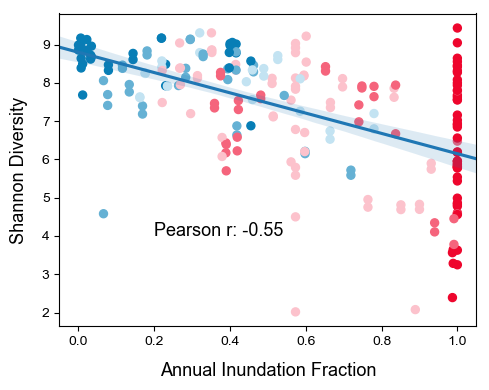

In [624]:
# plot shannon/depth/inundation
cmap_1 = ListedColormap(sns.diverging_palette(240, 10,s=99))
depth = env_data['cum_depth']
depth_norm = depth / depth.max()
depth_map = cmap_1(depth_norm)

f,ax = plt.subplots(figsize=[5,4])
sns.regplot(env_data['inundation_fraction-year_average'], AD_data['ShannonDiversity'], scatter_kws={'color':depth_map, 's':33},ax=ax)
ax.set_xlabel('Annual Inundation Fraction', fontsize=13, labelpad=10)
ax.set_ylabel('Shannon Diversity', fontsize=13, labelpad=10)
ax.text(.2, 4, 'Pearson r: -0.55',fontsize=13)
f.tight_layout()
f.savefig('AD_shannon_vs_depth_and_inundation.png', dpi=400)


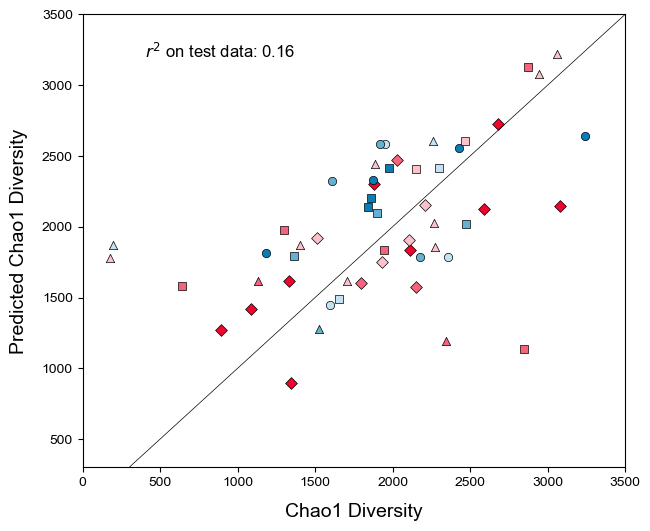

In [478]:
# Plot:
COLORS = depth_map
f,ax = plt.subplots(figsize=(7,6))

for i in range(55):
    ax.scatter(train_test[3][i], chao_pred[i], c=COLORS[i], marker = inundation_markers[i], edgecolors ='k', linewidths=.5)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, color='k', linewidth=.5)
ax.set_xlim([000, 3500])
ax.set_ylim([300, 3500])

# Annotations:
ax.set_ylabel("Predicted Chao1 Diversity", fontsize=14, labelpad=10)
ax.set_xlabel("Chao1 Diversity", fontsize=14, labelpad=10)
X_TEXT = 400
Y_TEXT = 3200
ax.text(X_TEXT, Y_TEXT, "$r^2$ on test data: {0}".format(round(chao_r2,2)), fontsize=12)
#f.savefig('../../output/AD_pred_vs_actual.png', dpi=400)

### Legends:

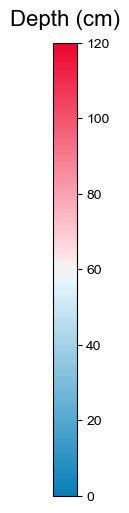

In [615]:
f,ax = plt.subplots(figsize=(.3,6))
norm = mpl.colors.Normalize(vmin=0, vmax=120)
cmap2 = sns.diverging_palette(240, 10,s=99, as_cmap=True)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap2,norm=norm)

ax.set_title('Depth (cm)', y=1.020, fontsize=16)

f.savefig('../../output/AD_fig_colorbar.png', dpi=400, bbox_extra_artists=(cb1.ax,), bbox_inches='tight', transparent=True)

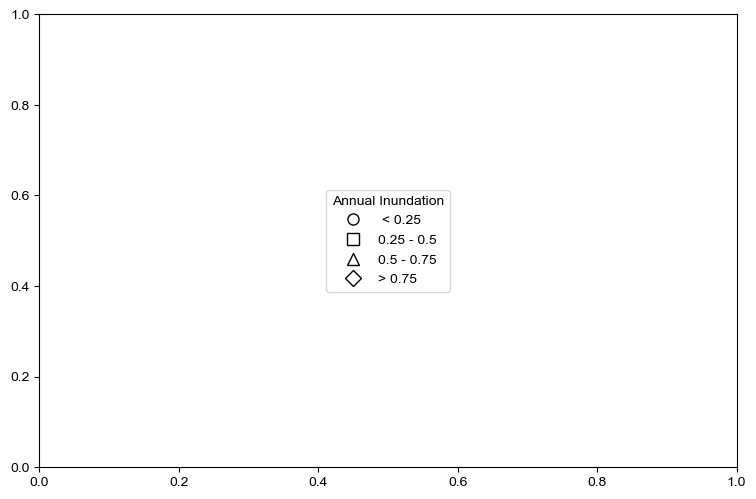

In [229]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label=' < 0.25',
                          markerfacecolor='w', markeredgecolor= 'k', markersize=8),
                   Line2D([0], [0], marker='s', color='w', label='0.25 - 0.5',
                          markerfacecolor='w', markeredgecolor= 'k', markersize=8),
                   Line2D([0], [0], marker='^', color='w', label='0.5 - 0.75',
                          markerfacecolor='w', markeredgecolor= 'k', markersize=8),
                   Line2D([0], [0], marker='D', color='w', label='> 0.75',
                          markerfacecolor='w', markeredgecolor= 'k', markersize=8),
                  ]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center', frameon=True, fancybox=True, title='Annual Inundation')
fig.savefig('../../output/AD_legend_1.png', dpi=400, transparent=True)

In [53]:
# Single environmental variables:
ad_array = np.array(AD_data['ShannonDiversity'])
for i in range(21):
    pearson_cor = stats.pearsonr(ad_array, env_data.iloc[:,i])
    if abs(pearson_cor[0]) > .1:
        print(env_data.columns[i])
        print(pearson_cor)

cum_depth
(-0.46487254354104185, 3.8534392059326637e-13)
z
(0.43025500381025583, 2.785157874645909e-11)
pH
(-0.37852169221537568, 7.1955984699906597e-09)
Organic_matter
(0.34109050977266647, 2.2813480988544141e-07)
inundation_fraction-year_average
(-0.55285507295386227, 6.2740861485970022e-19)
Pb
(0.26097164390765959, 9.3116604976867262e-05)
Cu
(-0.19270554864694836, 0.0042052681657638938)
Ca
(-0.24374376825749983, 0.00027104191091339411)
K
(-0.24374376825749983, 0.00027104191091339411)
Mg
(-0.29656694327648392, 8.0247545632606001e-06)
P
(0.14546908945711243, 0.031406351016328722)
Na
(-0.21683930041428626, 0.0012419327911515781)
Soiltype_Black CL
(0.23976544639303721, 0.0003432467048560699)
Soiltype_Brown CH
(-0.1718524143333589, 0.010846332518993407)
USDA_soil_Selma loam
(-0.26355286203954575, 7.8829267298321024e-05)
USDA_soil_Watseka loamy fine sand
(0.20986227305156888, 0.001791675538505352)


### Comparing Models of Alpha Diversity

I am taking a VERY simplified approach to see what is working & what doesn't make sense. SO far:

2. For Shannon Diversity: using a single parameter model (inundation) we can get a fit quality of 0.26 (~ Basically .55^2 as expected)
3. Can we beat this model with anything else? -> This is a relatively interesting question because we can now directly compare other modelling approach:
4. Using an extremely complicated "FULL" model, it doesn't seem like there are easy to find alphas that beat the simple model.
5. Using pH and depth, it seems possible to *slightly* beat inundation alone 

In [4]:
class lasso_variant():
    def __init__(self, env_data, ad_data, ALPHAS):
        self.env = np.array(env_data)
        if len(np.shape(self.env)) == 1:
            self.env = self.env.reshape(-1, 1)
        self.ad = np.array(ad_data)
        self.alphas = ALPHAS
        self.model_means = [0]*len(ALPHAS)
        self.model_std = [0]*len(ALPHAS)
        self.model_estimators = []

    def make_lasso_variant(self, printme=False):    
        """Build a model for each value of alpha"""
        index = 0 
        for alpha_val in self.alphas:
            lasso = linear_model.Lasso(alpha=alpha_val, copy_X=True, fit_intercept=True, max_iter=10000, normalize=True, positive=False, precompute=False, selection='cyclic', tol=0.00001, warm_start=False)
            self.env, self.ad = shuffle(self.env, self.ad)
            model_scores = cross_validate(lasso, self.env, self.ad, scoring=r2_scorer, cv=4, return_train_score=True, return_estimator=True, )
            self.model_estimators.append(model_scores)
            self.model_means[index] = model_scores['test_score'].mean()
            self.model_std[index] = model_scores['test_score'].std()            
            index +=1
            if printme:
                print('\nAlpha = {0}'.format(alpha_val))
                print('R2 = {0} +- {1}'.format(model_scores['test_score'].mean(), model_scores['test_score'].std()))            
        return self

In [53]:
full_model_coefs = pd.DataFrame(data = 0, index = list(range(4)), columns = full_model.columns) 
for i in range(4):
    full_model_coefs.loc[i, :] = full_lasso.model_estimators[10]['estimator'][i].coef_
full_lasso.model_estimators[10]['estimator']
#full_model_coefs.to_csv('../lasso_coefs.txt', sep='\t')

(Lasso(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=10000,
    normalize=True, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=1e-05, warm_start=False),
 Lasso(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=10000,
    normalize=True, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=1e-05, warm_start=False),
 Lasso(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=10000,
    normalize=True, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=1e-05, warm_start=False),
 Lasso(alpha=0.005, copy_X=True, fit_intercept=True, max_iter=10000,
    normalize=True, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=1e-05, warm_start=False))

In [5]:
# 1. Let's use ALL data, minimal predictors: ()
three_factor = env_data[['cum_depth', 'inundation_fraction-year_average', 'pH']]
inundation_only = env_data['inundation_fraction-year_average']
depth_only = env_data['cum_depth']
full_model = env_data

# 2. LASSO Setup and Alpha Comparison
r2_scorer = make_scorer(r2_score)
ALPHAS = [10, 5,2,1, .5,.2,.1, 0.05, 0.02, 0.01, .005, .002, .001, .0005, .0002, .0001, .00005, .00002, .00001,.000005, .000002, .000001,]

In [6]:
# Make class objects, then run lasso variants at all alphas:
three_factor_lasso = lasso_variant(three_factor, AD_data, ALPHAS=ALPHAS)
inundation_only_lasso = lasso_variant(inundation_only, AD_data, ALPHAS=ALPHAS)
depth_lasso = lasso_variant(depth_only, AD_data, ALPHAS=ALPHAS)
full_lasso = lasso_variant(full_model, AD_data, ALPHAS=ALPHAS)

three_factor_lasso.make_lasso_variant()
full_lasso.make_lasso_variant()
depth_lasso.make_lasso_variant()
inundation_only_lasso.make_lasso_variant()

/Users/jimbo/anaconda3/envs/skbio_py3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [ ]:
print(np.mean(three_factor_lasso.model_means[8:]))
np.mean(full_lasso.model_means[8:])

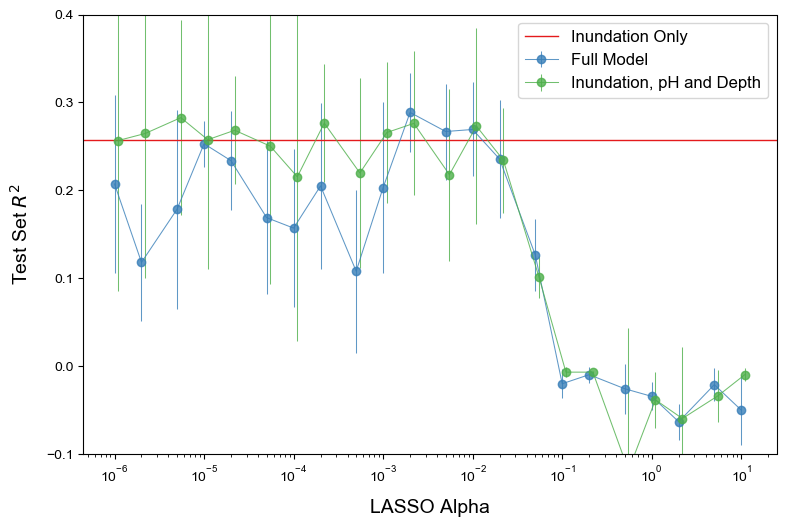

In [588]:
alpha_offset = [x+.1*x for x in ALPHAS]
colors = sns.color_palette('Set1')
inundation_cv_est = .257

f, ax = plt.subplots(figsize=[8,5.37])

ax.errorbar(ALPHAS, full_lasso.model_means, yerr = full_lasso.model_std, label='Full Model', alpha=.8, lw=.75, marker='o', color=colors[1])
ax.errorbar(alpha_offset, three_factor_lasso.model_means, yerr = three_factor_lasso.model_std, label='Inundation, pH and Depth', alpha=.8, lw=.75, marker='o', color=colors[2])
ax.axhline(inundation_cv_est, label='Inundation Only', color=colors[0], lw=1, alpha=1)


ax.legend(fontsize=12)
ax.set_xscale("log", nonposx='clip')
ax.set_ylim([-.1,.4])
ax.set_ylabel('Test Set $R^2$', fontsize=14, labelpad=10)
ax.set_xlabel('LASSO Alpha', fontsize=14, labelpad=10)
f.tight_layout()
f.savefig('../../output/LASSO_prediction_accuracy_vs_alpha.png', dpi=400)

In [ ]:
## e1,c1 = shuffle(e1, c1)
lasso = linear_model.Lasso(alpha=.000001, copy_X=True, fit_intercept=True, max_iter=10000, normalize=True, positive=False, precompute=False, selection='random', tol=0.00001, warm_start=False)
one_factor_scores = cross_validate(lasso, e1, c1,scoring=r2_scorer, cv=4, return_train_score=True, return_estimator=True )
print(one_factor_scores['test_score'].mean())
for i in range(4):
    print(one_factor_scores['estimator'][i].coef_)
two_param_mean_r2 = [0]*len(ALPHAS)
two_param_std_r2 = [0]*len(ALPHAS)
depth_mean_r2 = [0]*len(ALPHAS)
depth_std_r2 = [0]*len(ALPHAS)

In [472]:
# Compare Prediction accuracy across several alpha values:
index = 0 
for alpha_val in ALPHAS:
    lasso = linear_model.Lasso(alpha=alpha_val, copy_X=True, fit_intercept=True, max_iter=10000, normalize=True, positive=False, precompute=False, selection='cyclic', tol=0.00001, warm_start=False)
    
    # Shuffle data:
    e1,c1 = shuffle(e1, c1)
    e2,c2 = shuffle(e2, c2)

    
    
    one_factor_scores = cross_validate(lasso, e1, c1,scoring=r2_scorer, cv=4, return_train_score=True, return_estimator=True )
    print('\nOne factor: Alpha = {0}'.format(alpha_val))
    print('R2 = {0} +- {1}'.format(one_factor_scores['test_score'].mean(), one_factor_scores['test_score'].std()))

    two_factor_scores = cross_validate(lasso, e2, c2,scoring=r2_scorer, cv=4, return_train_score=True, return_estimator=True )
    print('\nTwo factor: Alpha = {0}'.format(alpha_val))
    print('R2 = {0} +- {1}'.format(two_factor_scores['test_score'].mean(), two_factor_scores['test_score'].std()))
    
    
    two_param_mean_r2[index] = two_factor_scores['test_score'].mean()
    two_param_std_r2[index] = two_factor_scores['test_score'].std()
    depth_mean_r2[index] = one_factor_scores['test_score'].mean()
    depth_std_r2[index] = one_factor_scores['test_score'].std()
    index +=1


One factor: Alpha = 10
R2 = -0.01138752135962351 +- 0.012343615998393448

Two factor: Alpha = 10
R2 = -0.04438331778869853 +- 0.015835761771646667

One factor: Alpha = 5
R2 = -0.02850825249725336 +- 0.013927812543592153

Two factor: Alpha = 5
R2 = -0.04110909559611797 +- 0.035849813775929176

One factor: Alpha = 2
R2 = -0.025679616304207675 +- 0.02261683250319454

Two factor: Alpha = 2
R2 = -0.017414734035092416 +- 0.011029085878681443

One factor: Alpha = 1
R2 = -0.020834767961412537 +- 0.019894469573253894

Two factor: Alpha = 1
R2 = -0.03217676118483248 +- 0.04606022996031034

One factor: Alpha = 0.5
R2 = -0.04479752436881884 +- 0.03797090372613139

Two factor: Alpha = 0.5
R2 = -0.00047385731209048654 +- 0.00047706140643199904

One factor: Alpha = 0.2
R2 = -0.019508944513987103 +- 0.01994521145937646

Two factor: Alpha = 0.2
R2 = -0.040821484107488926 +- 0.038452575269127764

One factor: Alpha = 0.1
R2 = -0.04666931872213581 +- 0.034450270184872296

Two factor: Alpha = 0.1
R2 = -0.

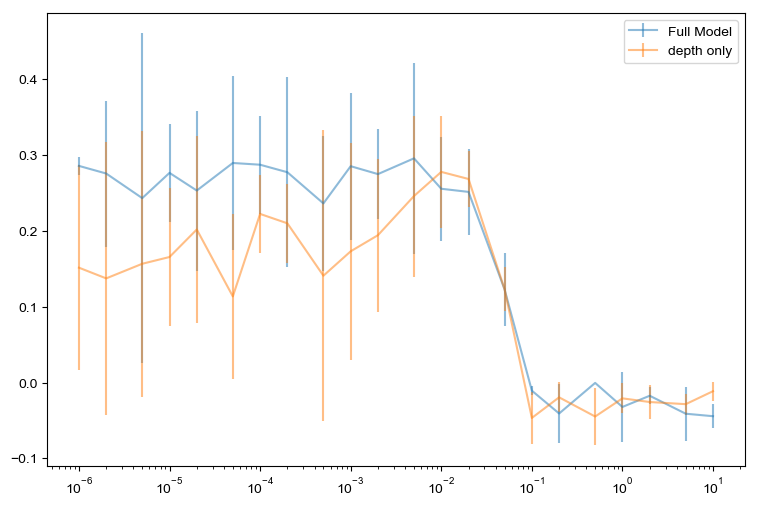

In [473]:
f,ax = plt.subplots()
ax.errorbar(ALPHAS, two_param_mean_r2, yerr = two_param_std_r2, label='Full Model', alpha=.5)
ax.errorbar(ALPHAS, depth_mean_r2, yerr = depth_std_r2, label='depth only', alpha=.5)
ax.set_xscale("log", nonposx='clip')
ax.legend()

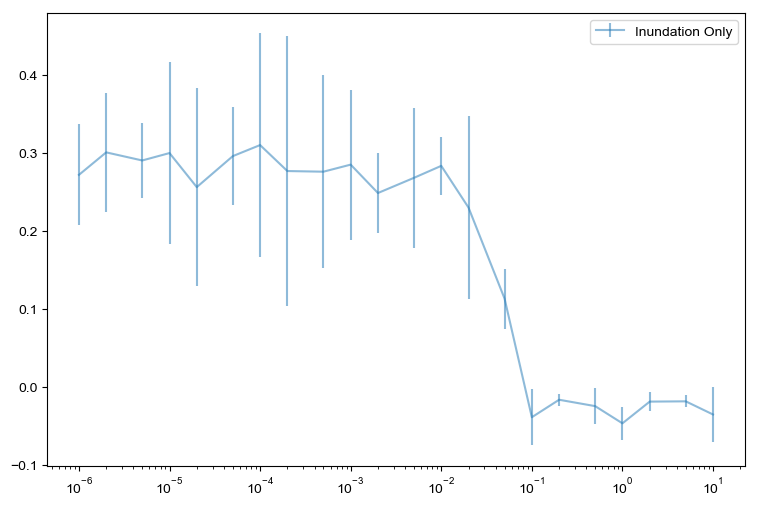

In [454]:
f,ax = plt.subplots()
ax.errorbar(ALPHAS, depth_mean_r2, yerr = depth_std_r2, label='Inundation Only', alpha=.5)
ax.set_xscale("log", nonposx='clip')
ax.legend()

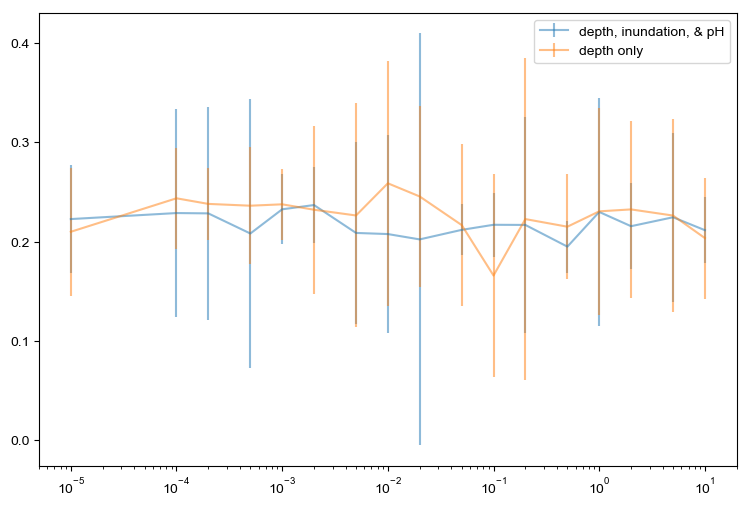

In [418]:
f,ax = plt.subplots()
ax.errorbar(ALPHAS, two_param_mean_r2, yerr = two_param_std_r2, label='depth, inundation, & pH', alpha=.5)
ax.errorbar(ALPHAS, depth_mean_r2, yerr = depth_std_r2, label='depth only', alpha=.5)
ax.set_xscale("log", nonposx='clip')
ax.legend()

In [27]:
## Simple LM w/ soiltype:

formula_df.columns = [x.replace(' ', '_') for x in formula_df.columns]
formula_df.columns = [x.replace('-', '_') for x in formula_df.columns]
model = smf.ols(formula="ShannonDiversity ~ inundation_fraction_year_average", data=formula_df).fit()
model.summary()
# 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       ShannonDiversity   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     95.52
Date:                Tue, 23 Oct 2018   Prob (F-statistic):           6.27e-19
Time:                        14:21:27   Log-Likelihood:                -367.73
No. Observations:                 219   AIC:                             739.5
Df Residuals:                     217   BIC:                             746.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            8.7970      0.176     50.104      0.000       8.451       9.143
inundation_fraction_year_average    -2.6483      0.271     -9.774      0.000      -3.182      -2.114
==============================================================================
Omnibus:                       27.141   Durbin-Watson:                   1.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.704
Skew:                          -0.758   Prob(JB):                     3.94e-09
Kurtosis:                       4.394   Cond. No.                         4.13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
formula_df = pd.concat([AD_data, env_data], axis=1)
formula_df.columns
groups = formula_df.groupby('USDA_soil_series')

In [38]:
diversity = {}
for i,grp in groups: 
    diversity[i] = grp['ShannonDiversity']

In [44]:
print(diversity.keys())
stats.f_oneway(diversity['Hoopeston fine sandy loam'], diversity['Watseka loamy fine sand'], diversity['Selma loam'])

dict_keys(['Hoopeston fine sandy loam', 'Watseka loamy fine sand', 'Selma loam'])


F_onewayResult(statistic=8.3768913144912602, pvalue=0.00031344140988446087)

In [47]:
for i in diversity.values():
    print(np.mean(i))

7.5680760424
7.78906908694
6.88099955162


In [48]:
print(AD_data.mean())

ShannonDiversity    7.31243
dtype: float64
